In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt(
    '3wavelengths_try1.dat',
    skiprows=1,
    delimiter=','
)

In [3]:
def func2(x):
    
    f = [
        x[0] * np.cos(x[1]) - 4,
        x[1] * x[0] - x[1] - 5
        ]
    
    df = np.array([
        [np.cos(x[1]), -x[0] * np.sin(x[1])],
        [x[1],          x[0] - 1]
        ])
    
    return f, df

sol = opt.root(func2, [1, 1], jac=True, method='lm')
sol.x

array([6.50409711, 0.90841421])

In [4]:
phoh, od_380, od_400, od_365 = data.T

### Outline of problem

Unknowns: 



In [5]:
con_N0 = 7.5 * 1e-6
eps_N = od_380[0] / con_N0 
con_X = phoh

def con_NX(K1, K2):
    
    con = (
        K1 * con_N0 * con_X
        )/(
        1 + K1*con_X + K1*K2*con_X**2.
        )
    
    return con

def con_NX2(K1, K2):
    
    con = con_NX(K1, K2) * K2 * con_X
    
    return con
    

In [6]:
eps_N

26759.611085404536

In [7]:
def con_N(K1, K2):
    
    con = con_N0 - con_NX(K1, K2) - con_NX2(K1, K2)
    
    return con

In [52]:
def em_fun_at_380(unknowns):
    """ System of equations """
    K1, K2 = unknowns[:2]
    eps_NX = unknowns[2]#*1e5
    eps_NX2 = unknowns[3]#*1e4
    
    f = (
        eps_N * con_N(K1, K2)
        + 
        eps_NX * con_NX(K1, K2) 
        +
        eps_NX2 * con_NX2(K1, K2)
        ) - od_380
    
    return f

In [53]:
def d_NX_d_K1(K1, K2):
    
    first_term = (
        con_N0 * con_X 
        * 
        (1 + K1*con_X + K1*K2*con_X**2.)**(-1.)
        )
    
    second_term = (
        K1 * con_N0 * con_X 
        *
        (-1)*(1 + K1*con_X + K1*K2*con_X**2.)**(-2.)
        *
        (con_X + K2*con_X**2.)
        )
    
    return first_term + second_term


def d_NX2_d_K1(K1, K2):
    
    return con_X * K2 * d_NX_d_K1(K1, K2) 


def d_NX_d_K2(K1, K2):
    
    der = (
        K1*con_N0*con_X
        *
        (-1)*(1 + K1*con_X + K1*K2*con_X**2.)**(-2.)
        *
        K1*con_X**2.
        )
    
    return der


def d_NX2_d_K2(K1, K2):
    
    der = con_X * (
        con_NX(K1, K2) 
        + 
        K2 * d_NX_d_K2(K1, K2)
        )
    
    return der


def d_N_d_K1(K1, K2):
    
    return -d_NX_d_K1(K1, K2) - d_NX2_d_K1(K1, K2)
    
    
def d_N_d_K2(K1, K2):
    
    return -d_NX_d_K2(K1, K2) - d_NX2_d_K2(K1, K2)


def jaco(unknowns):
    
    K1, K2 = unknowns[:2]
    eps_NX = unknowns[2]#*1e5
    eps_NX2 = unknowns[3]#*1e4
    
    ## Take derivitives with respect to K1
    ddk1 = (
        eps_N*d_N_d_K1(K1, K2)
        +
        eps_NX*d_NX_d_K1(K1, K2)
        +
        eps_NX2*d_NX2_d_K1(K1, K2)
        )
    
    ddk2 = (
        eps_N*d_N_d_K2(K1, K2)
        +
        eps_NX*d_NX_d_K2(K1, K2)
        +
        eps_NX2*d_NX2_d_K2(K1, K2)
        )
    
    ddepsNX = con_NX(K1, K2)
    
    ddepsNX2 = con_NX2(K1, K2)
    
    j = np.vstack((ddk1, ddk2, ddepsNX, ddepsNX2))
    
    return j.T

In [54]:
jaco([1, 1, 1, 1])

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.77921490e-03, -1.66708122e-04,  2.16160944e-07,
         6.42062209e-09],
       [-1.10769049e-02, -6.15383606e-04,  4.15309446e-07,
         2.44299674e-08],
       [-1.59027354e-02, -1.27789838e-03,  5.98476371e-07,
         5.22940518e-08],
       [-2.02741056e-02, -2.09732127e-03,  7.66710354e-07,
         8.84665793e-08],
       [-2.42137016e-02, -3.02671270e-03,  9.21052632e-07,
         1.31578947e-07],
       [-2.77475432e-02, -4.02786917e-03,  1.06251856e-06,
         1.80427680e-07],
       [-3.09034620e-02, -5.07009924e-03,  1.19208460e-06,
         2.33960529e-07],
       [-3.37099479e-02, -6.12908143e-03,  1.31067961e-06,
         2.91262136e-07],
       [-3.61952979e-02, -7.18583120e-03,  1.41917958e-06,
         3.51539896e-07],
       [-3.83870097e-02, -8.22578780e-03,  1.51840491e-06,
         4.14110429e-07],
       [-4.27504437e-02, -1.06876109e-02,  1.73076923e-06,
      

In [55]:
np.linalg.matrix_rank(jaco([1,1,1,1]))

4

In [56]:
em_fun_at_380([1, 2, 3, 4])

array([ 0.        , -0.14390034, -0.24184778, -0.31333689, -0.36617268,
       -0.4111514 , -0.44836636, -0.47965839, -0.50653766, -0.52835587,
       -0.54814289, -0.58742535, -0.60678983, -0.62060764, -0.62945066,
       -0.63483522, -0.63942573, -0.63972339, -0.6396838 , -0.6393554 ,
       -0.63802677])

In [57]:
from scipy.optimize import Bounds

In [61]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1]

# sol = opt.root(
#     em_fun_at_380, 
#     ini_guess, 
# #     jac=jaco, 
#     method='lm',
# #     bounds=Bounds([0], [np.inf])
# )

sol = opt.least_squares(
    em_fun_at_380, 
    ini_guess, 
#     jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [62]:
sol.success

True

In [63]:
sol

 active_mask: array([ 0,  0,  0, -1])
        cost: 0.00010986484678516483
         fun: array([ 0.        , -0.00633294, -0.00475546, -0.00141617,  0.00367149,
        0.00455645,  0.00431156,  0.00324973,  0.00137559,  0.00043335,
       -0.00179454, -0.00799151, -0.00343979, -0.00119496,  0.00049218,
        0.0016331 ,  0.00061278,  0.00167486,  0.00140605,  0.00016061,
       -0.00104628])
        grad: array([ 6.23554176e-11,  4.39075729e-11, -8.25903406e-16,  4.36736131e-10])
         jac: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.84277566e-02, -1.49674714e-03,  1.13785253e-06,
         1.49011612e-08],
       [ 2.72798682e-02, -6.51060417e-03,  1.95129871e-06,
         5.21540642e-08],
       [ 3.13695655e-02, -1.46982409e-02,  2.55417222e-06,
         1.04308128e-07],
       [ 3.29604390e-02, -2.52912194e-02,  3.01313854e-06,
         1.63912773e-07],
       [ 3.31982975e-02, -3.75661328e-02,  3.36978624e-06,
         2.235

In [64]:
def Absorbance_380(params):
    
    return em_fun_at_380(params)+od_380

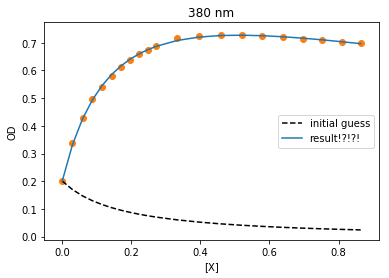

In [65]:

## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_380(ini_guess), 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_380(sol.x), label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_380, c='C1')
plt.title('380 nm')
plt.legend()


In [66]:
fit_params = sol.x

### Try with Jacobian

In [70]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1]

sol_jac = opt.least_squares(
    em_fun_at_380, 
    ini_guess, 
    jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [71]:
sol_jac

 active_mask: array([ 0,  0,  0, -1])
        cost: 0.00010986484678516345
         fun: array([ 0.        , -0.00633295, -0.00475546, -0.00141617,  0.00367149,
        0.00455645,  0.00431156,  0.00324973,  0.00137559,  0.00043335,
       -0.00179454, -0.00799151, -0.00343979, -0.00119496,  0.00049218,
        0.0016331 ,  0.00061278,  0.00167486,  0.00140605,  0.00016061,
       -0.00104628])
        grad: array([ 6.82643303e-11,  1.98063948e-10, -9.13825135e-18,  3.34970033e-10])
         jac: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.84277567e-02, -1.49674884e-03,  1.13785253e-06,
         1.56028466e-08],
       [ 2.72798681e-02, -6.51060642e-03,  1.95129871e-06,
         5.29898654e-08],
       [ 3.13695663e-02, -1.46982405e-02,  2.55417220e-06,
         1.03032310e-07],
       [ 3.29604404e-02, -2.52912222e-02,  3.01313853e-06,
         1.60503677e-07],
       [ 3.31982993e-02, -3.75661228e-02,  3.36978624e-06,
         2.222

In [72]:
## Compare computed Jacobian at solution to analytic 
(sol.jac - jaco(sol.x))/(sol.jac)

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[            nan,             nan,             nan,
                    nan],
       [ 2.21890330e-10, -1.14182090e-06, -2.02126580e-09,
        -4.70893063e-02],
       [ 7.75894613e-09, -3.50876941e-07, -3.67617577e-09,
        -1.60256146e-02],
       [-1.57661555e-08,  2.23860715e-08,  4.61594667e-09,
         1.22312491e-02],
       [-3.29989136e-08, -1.15970217e-07,  3.38483176e-10,
         2.07982408e-02],
       [-4.52540491e-08,  2.63442015e-07, -4.27314156e-09,
         5.71492832e-03],
       [-7.68108819e-09,  1.95334043e-07, -1.36590410e-08,
         1.48874931e-02],
       [ 2.71318470e-08,  4.96830146e-08,  3.73661874e-09,
        -3.00349057e-03],
       [-3.09190821e-08,  5.30784252e-08, -1.31762369e-10,
         2.16451597e-03],
       [ 2.35303059e-08, -3.65209274e-08, -3.41802837e-09,
         6.84441554e-03],
       [ 1.60333021e-09,  2.25901715e-08,  8.35661829e-09,
         1.19158259e-02],
       [ 9.74161291e-09, -4.14913610e-08, -2.68152890e-09,
      

In [74]:
## Compare resulting parameters
(sol.x - sol_jac.x)/sol.x

array([ 6.70901216e-09, -1.04595670e-08, -2.96369722e-09,  4.90330879e-01])

In [75]:
sol.x

array([6.03599347e+00, 4.61655459e-01, 1.42647084e+05, 9.56137502e-11])

In [76]:
sol_jac.x

array([6.03599343e+00, 4.61655464e-01, 1.42647084e+05, 4.87313761e-11])